# Week 8 - Conversation and Text Generation
Many natural language activities boil down to text generation, especially the back-and-forth nature of natural conversation and question answering. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

Much 2022 NLP research is on text generation. Most famously, this is the primary use of large language models like GPT-3 (OpenAI), Wu Dao (Beijing Academy of AI), and Gopher (DeepMind).

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
!pip install -U git+git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git
import lucem_illud #

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import seaborn as sns
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os
import io
import zipfile

import networkx as nx

%matplotlib inline

!pip install torch
import torch # 
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split

!pip install transformers
from transformers import BertTokenizer, BertConfig # 
from transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange

  Running command git clone -q git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git 'C:\Users\Rando\AppData\Local\Temp\pip-req-build-7l75d59n'
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.25.1 requires six>=1.13.0, but you have six 1.12.0 which is incompatible.
elasticsearch 6.1.1 requires urllib3<1.23,>=1.21.1, but you have urllib3 1.26.8 which is incompatible.
You should consider upgrading via the 'C:\Softwares\Anaconda3\envs\pytorch_gpu\python.exe -m pip install --upgrade pip' command.


  Cloning git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to c:\users\rando\appdata\local\temp\pip-req-build-7l75d59n
  Resolved git://github.com/UChicago-Computational-Content-Analysis/lucem_illud.git to commit 9fa6f1abdc19d159d587b4017ee6897fe7a18d4d
  Using cached urllib3-1.26.8-py2.py3-none-any.whl (138 kB)
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.22
    Uninstalling urllib3-1.22:
      Successfully uninstalled urllib3-1.22


C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


You should consider upgrading via the 'C:\Softwares\Anaconda3\envs\pytorch_gpu\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Softwares\Anaconda3\envs\pytorch_gpu\python.exe -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

In [3]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras.preprocessing.sequence import pad_sequences

# ConvoKit
As we alluded to in Week 6 with causal inference, [ConvoKit](https://convokit.cornell.edu/) is an exciting platform for conversational analysis developed by Jonathan Chang, Calem Chiam, and others, mostly at Cornell. Keep this in mind if you are interested in a final project with conversational data such as Twitter threads or movie scripts. They have an [interactive tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), which we include some examples from below. Most of the following text and code is authored by them.

These ConvoKit corpora can be used for the next exercise in this notebook.

In [4]:
try:
    import convokit
except ModuleNotFoundError:
    !pip install convokit

In [5]:
# for pretty printing of cells within the Colab version of this notebook
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [6]:
import convokit
from convokit import Corpus, download

### Loading a Corpus

A Corpus represents a conversational dataset. We typically begin our analysis by loading a Corpus. A list of existing datasets already in ConvoKit format can be found [here](https://convokit.cornell.edu/documentation/datasets.html). 

A growing list of many other conversational datasets covering a variety of conversational settings are available in ConvoKit, such as face-to-face (e.g. the [*Intelligence Squared Debates corpus*](https://convokit.cornell.edu/documentation/iq2.html)), institutional (e.g. the [*Supreme Court Oral Arguments corpus*](https://convokit.cornell.edu/documentation/supreme.html)), fictional (e.g. the [*Cornell Movie Dialog Corpus*](https://convokit.cornell.edu/documentation/movie.html)), or online  (e.g. all talkpage conversations on [*Wikipedia Talk Pages*](https://convokit.cornell.edu/documentation/wiki.html) and a full dump of [*Reddit*](https://convokit.cornell.edu/documentation/subreddit.html)).

For this tutorial, we will primarily be using the *r/Cornell* subreddit corpus to demo various ConvoKit functionality, and occasionally the [*Switchboard Dialog Act Corpus*](https://convokit.cornell.edu/documentation/switchboard.html) (a collection of anonymized five-minute telephone conversations) as a contrasting dataset.

In [ ]:
corpus = Corpus(download('subreddit-Cornell'))

# You can try a different corpus if you want.
#corpus = Corpus(download('diplomacy-corpus'))
#corpus = Corpus(download('switchboard-corpus'))
#corpus = Corpus(download('reddit-corpus-small'))

Dataset already exists at C:\Users\Rando\.convokit\downloads\subreddit-Cornell


In [ ]:
corpus.print_summary_stats()

Number of Speakers: 7568
Number of Utterances: 74467
Number of Conversations: 10744


### Corpus components: Conversations, Utterances, Speakers

Every Corpus has three main components: [Conversations](https://convokit.cornell.edu/documentation/conversation.html), [Utterances](https://convokit.cornell.edu/documentation/utterance.html), and [Speakers](https://convokit.cornell.edu/documentation/speaker.html). Just as in real life, in ConvoKit, Conversations are some sequence of Utterances, where each Utterance is made by some Speaker. Let's look at an example of each.

In [ ]:
# This is a Reddit thread
corpus.random_conversation().meta

{'title': 'Is it difficult living on a graduate student stipend in Ithaca?',
 'num_comments': 9,
 'domain': 'self.Cornell',
 'timestamp': 1426973697,
 'subreddit': 'Cornell',
 'gilded': 0,
 'gildings': None,
 'stickied': False,
 'author_flair_text': ''}

In [ ]:
# This is a Reddit post or comment.
corpus.random_utterance().meta

{'score': 7,
 'top_level_comment': None,
 'retrieved_on': 1502151630,
 'gilded': 0,
 'gildings': None,
 'subreddit': 'Cornell',
 'stickied': False,
 'permalink': '/r/Cornell/comments/6pxxpt/book_list/',
 'author_flair_text': ''}

In [ ]:
# The r/Cornell Corpus does not have speaker metadata.
#corpus.random_speaker().meta

#Speaker do have an 'id' which is their Reddit username, as seen here.
corpus.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x0000024933105D60>, 'id': 'Heartran_ran'})

In [ ]:
# We can iterate through these objects as we iterate lists or DataFrames in Python.
for utt in corpus.iter_utterances():
    print(utt.text)
    break 

I was just reading about the Princeton Mic-Check and it's getting [national press](http://www.bloomberg.com/news/2011-12-29/princeton-brews-trouble-for-us-1-percenters-commentary-by-michael-lewis.html).

I want to get a sense of what people felt like around campus. Anything interesting happen? Anything interesting coming up?


Conversations, Utterances, and Speakers are each interesting, but the magic of conversational analysis is connecting them. For example, we can get all the Conversations in which a Speaker has participated and all the Utterances they have made. To make it more interesting, we can find a Speaker to study by navigating from a random Utterance.

In [ ]:
# consider this sequence of operations that highlight how to navigate between components
utt = corpus.random_utterance()
convo = utt.get_conversation() # get the Conversation the Utterance belongs to
spkr = utt.speaker # get the Speaker who made the Utterance

spkr_convos = list(spkr.iter_conversations())

# Display up to 3 of their conversations.
spkr_convos[:3]

[Conversation({'obj_type': 'conversation', 'meta': {'title': 'Affording Cornell?', 'num_comments': 20, 'domain': 'self.Cornell', 'timestamp': 1459902327, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x0000024933105D60>, 'id': '4djcrn'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Class of 2020 Acceptance Rate', 'num_comments': 4, 'domain': 'self.Cornell', 'timestamp': 1460150175, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_text': ''}, 'vectors': [], 'tree': None, 'owner': <convokit.model.corpus.Corpus object at 0x0000024933105D60>, 'id': '4dyghk'}),
 Conversation({'obj_type': 'conversation', 'meta': {'title': 'Best Pizza near Ithaca?', 'num_comments': 22, 'domain': 'self.Cornell', 'timestamp': 1460748267, 'subreddit': 'Cornell', 'gilded': 0, 'gildings': None, 'stickied': False, 'author_flair_t

For a more qualitative feel of the data, you can display a Conversation. For Reddit data, this is a single thread.

In [ ]:
# We truncate sentences at character 80 to avoid making this notebook too long!
convo.print_conversation_structure(lambda utt: utt.text[:80] + "\n")

I know that there is a riflery PE class at Cornell. I was unable to fit into thi

    I personally don't know, but if you get the name of the person running the class

    Pm me 

    There's a rod &amp; gun club in Lansing if you can't get access. 

I bet there's

        are there any you can bus to, and do they rent guns as well, I am a freshman so 

            Try google maps...failing that, Uber is upstate now.

I would go visit, most gun

    The range is up in Lansing, it's about a 15 minute ride by car from the main cam



There is a lot more to ConvoKit that we encourage you to explore, especially their [tutorial](https://colab.research.google.com/github/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/Introduction_to_ConvoKit.ipynb), but the ability to seamlessly navigate between the Utterances, Conversations, and Speakers of a Corpus is extremely valuable for social science.

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that use ConvoKit to analyze a Corpus other than 'subreddit-Cornell', including at least one function you find in the package not used above. You can also generate a ConvoKit Corpus from your own dataset based on [their Corpus from .txt files tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/converting_movie_corpus.ipynb) or [their Corpus from pandas tutorial](https://github.com/CornellNLP/Cornell-Conversational-Analysis-Toolkit/blob/master/examples/corpus_from_pandas.ipynb), but that may be time-consuming for a weekly assignment. (It could be a great idea for your final project!)

In [7]:
friends = Corpus(download('friends-corpus'))

Dataset already exists at C:\Users\Rando\.convokit\downloads\friends-corpus


In [8]:
friends.print_summary_stats()

Number of Speakers: 700
Number of Utterances: 67373
Number of Conversations: 3107


In [9]:
friends.random_conversation().meta

{'season': 's03', 'episode': 'e04', 'scene': 'c09'}

In [10]:
friends.random_utterance().meta

{'tokens': [['Sure', 'you', 'do', '.']],
 'character_entities': None,
 'emotion': None,
 'caption': [1187436, 1189312, 'sure you do'],
 'transcript_with_note': None,
 'tokens_with_note': None}

In [11]:
friends.random_utterance()

Utterance({'obj_type': 'utterance', 'meta': {'tokens': [['I', 'know', '.'], ['A', 'double', 'blind', 'date', ',', 'and', 'we', 'both', 'get', 'stood', 'up', '.'], ['What', 'are', 'the', 'chances', '?']], 'character_entities': None, 'emotion': None, 'caption': None, 'transcript_with_note': None, 'tokens_with_note': None}, 'vectors': [], 'speaker': Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x000002A35588D2B0>, 'id': 'Ross Geller'}), 'conversation_id': 's09_e14_c15_u000', 'reply_to': 's09_e14_c15_u001', 'timestamp': None, 'text': 'I know. A double blind date, and we both get stood up. What are the chances?', 'owner': <convokit.model.corpus.Corpus object at 0x000002A35588D2B0>, 'id': 's09_e14_c15_u002'})

In [12]:
friends.random_speaker().meta

{}

We can see that there is meta information about speaker in this corpus.

In [13]:
friends.random_speaker()

Speaker({'obj_type': 'speaker', 'meta': {}, 'vectors': [], 'owner': <convokit.model.corpus.Corpus object at 0x000002A35588D2B0>, 'id': 'Charity Guy'})

The speaker object only contains the speaker's name, which can be used to connect to each utterance.

In [14]:
print(friends.has_speaker('Monica Geller'))
print(friends.has_speaker('Rachel Green'))
print(friends.has_speaker('Phoebe Buffay'))
print(friends.has_speaker('Joey Tribbiani'))
print(friends.has_speaker('Chandler Bing'))
print(friends.has_speaker('Ross Geller'))

True
True
True
True
True
True


Here I used ``has_speaker`` to check if the main characters are all in the corpus.

In [15]:
from convokit import FightingWords
fw = FightingWords()

Initializing default CountVectorizer with ngram_range (1, 3)... Done.


In [16]:
fw.fit(friends, class1_func = lambda utt: utt.speaker.id == 'Ross Geller',
       class2_func = lambda utt: utt.speaker.id == 'Joey Tribbiani')

class1_func returned 9161 valid corpus components. class2_func returned 8215 valid corpus components.
Vocab size is 3818
Comparing language...
ngram zscores computed.


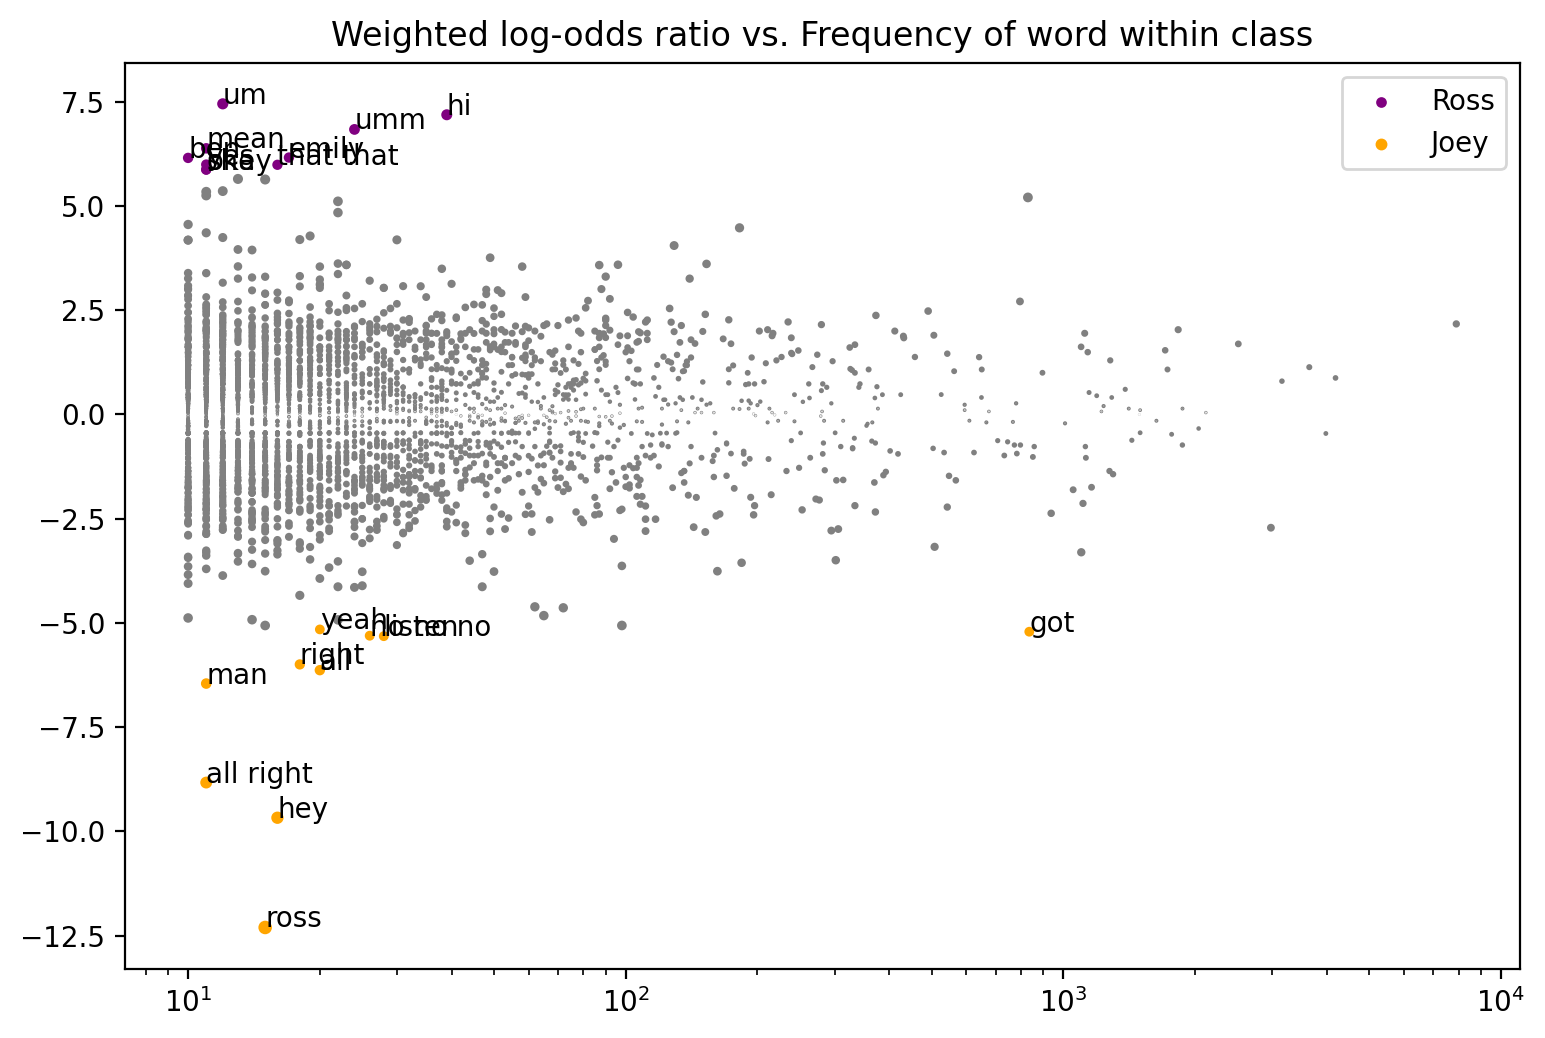

,z-score,class
ngram,,
ross,-12.302680,Joey
hey,-9.671244,Joey
all right,-8.827693,Joey
man,-6.453863,Joey
all,-6.132868,Joey
...,...,...
emily,6.159163,Ross
mean,6.380617,Ross
umm,6.833959,Ross


In [18]:
fw.summarize(friends, plot=True, class1_name='Ross', class2_name='Joey')

Here I compared utterances by **Ross** and **Joey**. **Ross** has a comparatively rigid personality, while **Joey** is more outgoing and flexible. </br>
We can see that **Joey** has more confirmative words like ``yeah``, ``right``, and ``all right``. Also he uses ``hey`` instead of ``hi``, which is more active. On the other hand, **Ross** uses words like ``ummm`` and ``um``, indicating he has a lot hesitation. Also, Ross uses ``hi`` for greetings.

## Creating networks of agents from corpora

Now let's return to the Davies corpora (specifically, Soap Operas) to see how we can extract actors and build a network of their relationships in the texts.

We'll use the `lucem_illud.loadDavies()` function to get the dataframe. Make sure to download `SOAP.zip` from DropBox, unzip, and edit the following line with the path to that file. This code may take some time.

In [ ]:
corpora_address = "SOAP"

In [ ]:
soap_texts = lucem_illud.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


C:\Softwares\Anaconda3\envs\pytorch_gpu\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


We now use the source to see how the data is stored. Note that this is different from the movies corpus, and that we will need to use a different aggregating method to store the data. Each dataset would have a different approach, but they are all very similar, it depends on how the data is stored. Here multiple textids match multiple scripts, so our soap dataframe would be structured a little differently. 

You can see the first 20 lines of the source file here.

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
source[0:20]

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

We now have each Soap, and each of the Tokenized texts. Let us see what kind of information we can get. These are American soap operas, and are likely to be cheesy and dramatic (an understatment). A fun start would be to make networks of each of the actors and actresses in these soaps. 

What would be a good way to create a network? Maybe everytime someone talks to someone we add one weight? But we wouldn't want to add weights whenever it's a different scene - or maybe we do? Let us look at the text and figure it out.

Note that we didn't add the year here because it spans over multiple years. If we are doing different kinds of analysis we would want to a years column as well.

In my dataframe, Days of Our Lives is the 4th corpora, and I conducted my basic analysis on that.

In [ ]:
dool = soap_df['Tokenized Texts'][3]

In [ ]:
' '.join(dool[0:1500])

Hmmm... we can't do our normal text processing. But this provides us with an interesting oppurtunity: every '@!' is followed by some useeful information. Let us do a quick check of how many characters exist here, and how many times they speak.

In [ ]:
characters = {}

In [ ]:
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1


In [ ]:
len(characters)

Wow, that's a lot of characters: but we notice a '@!' between certain actions too, such as screaming and sobbing. Let us maybe only look for characters with a high number of appearances?

In [ ]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Let's check these folks out on the interwebz...a image of search of the name + "days of our lives":

In [ ]:
Image(filename='../data/dool/dool_john.png') 

In [ ]:
Image(filename='../data/dool/dool_brady.jpg') 

In [ ]:
# Image(filename='../data/dool/dool_hope.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_philip.jpeg')

In [ ]:
# Image(filename='../data/dool/dool_marlena.jpg')

In [ ]:
# Image(filename='../data/dool/dool_kate.png')

In [ ]:
# Image(filename='../data/dool/dool_bo.png')

In [ ]:
# Image(filename='../data/dool/dool_chloe.jpg')

In [ ]:
# Image(filename='../data/dool/dool_sami.jpg')

In [ ]:
# Image(filename='../data/dool/dool_shawn.jpg')

In [ ]:
# Image(filename='../data/dool/dool_belle.jpg')

In [ ]:
# Image(filename='../data/dool/dool_lucas.jpg')

In [ ]:
# Image(filename='../data/dool/dool_nicole.jpg')

These are definitely big, long-time players in the dramatic Days narrative. It would make sense to create a graph where each character who appears over 2000 times is a node, and each time they talk to each other, we add one to their weight. We should also store all the things these chracters say: that's useful information.

So we now iterate through the tokens in a manner where we can capture this information.

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
len(actor_network.nodes.data())

In [ ]:
actor_network.nodes.data()

In [ ]:
actor_network.nodes['Sami']['lines_spoken']

In [ ]:
i = 0

The following lines of code creates the graph of actors and their relationships.

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

In [ ]:
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network))

In [ ]:
c

### Finding structure in networks

We now have a lot of useful information: we have a graph of all the characters, with their relationships with other characters, as well as all the words they've said. We tried finding communities, but it seems like everyone is connected to everyone: each of them form their own 'community'. Seems like people talk to each other a bunch in soaps.

This is however, not the best network to find any meaningful patterns, as we can see with everyone connected to everyone. But as we can see with our heatmap, not everyone talks to everyone an equal amount. How about we only keep our "important" ties, where people are talking to each other a lot?

In [ ]:
smaller_actor_network = nx.Graph()

In [ ]:
for actor_1 in actor_network.nodes():
    smaller_actor_network.add_node(actor_1, lines_spoken= actor_network.nodes[actor_1]['lines_spoken'], words=actor_network.nodes[actor_1]['words'])
    for actor_2 in actor_network.nodes():
        if actor_2!=actor_1 and actor_network.edges[(actor_1, actor_2)]['weight'] > 250:
            smaller_actor_network.add_edge(actor_1, actor_2, weight=actor_network.edges[(actor_1, actor_2)]['weight'])


In [ ]:
nx.draw(smaller_actor_network, with_labels=True, font_weight='bold')

This is a lot more interesting: while the sets of characters overlap, there is still two distinct communities if you look at characters who regularly talk to each other!

Let us see what our centrality measures look like, as well as communities.

In [ ]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(smaller_actor_network))

In [ ]:
c

In [ ]:
dcentralities = nx.degree_centrality(smaller_actor_network)

In [ ]:
dcentralities['John'], dcentralities['Philip']

Our two different communities show up as detected by the networkx algorithm, and when we look at centralities, we can see that John is a lot more central than Philip.

Let us go back to our original graph, and see if the weight or number of similar appearences matches the text... how do we do this? Well, we already have the graph, and we also have information of who spoke to who. So we have our framework!

This means we can explore ideas contained in two of the papers you will be reading: . “No country for old members: User lifecycle and linguistic change in online communities.”, and  “Fitting In or Standing Out? The Tradeoffs of Structural and Cultural Embeddedness”, both of which you can access on Canvas. 

Let us use a simplified version of the papers, and check if a higher number of conversations might lead to a higher similarity between the word distributions for two characters. We can use the same divergences we used in the last notebook. Do you think it will match with the number of times each character was associated with each other?

In [ ]:
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pd.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pd.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [ ]:
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud.normalizeTokens(character_words))

In [ ]:
L = []

In [ ]:
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pd.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

In [ ]:
# np.corrcoef(M_, M)[0]

With our two heatplots, we can attempt to do some rudimentary analysis. We can see from our previous plot that Shawn and Belle talk to each other a lot, so do Hope and Bo, and Nicole and Brady, and Lucas and Sami. Do they also talk *like* each other?

Kind of, actually: all four of these pairs have a lower distance between them. Now I don't know anything about this particular soap... are these four pairs related? Are they in a relationship, either married or dating, or are they just really good friends?

This lays out the frameworks which you can now use to explore your own networks. 

# Interactional influence

Before we utilize transformers, let's see how to estimate the influence of one speaker on another in order to estimate a kind of interpersonal influence network based on a recent paper by Fangjian Guo, Charles Blundell, Hanna Wallach, and Katherine Heller entitled ["The Bayesian Echo Chamber: Modeling Social Influence via Linguistic Accommodation"](https://arxiv.org/pdf/1411.2674.pdf). This relies on a kind of point process called a Hawkes process that estimate the influence of one point on another. Specifically, what they estimate is the degree to which one actor to an interpersonal interaction engaged in "accomodation" behaviors relative to the other, generating a directed edge from the one to the other.

### First let's look at the output of their analysis:

In [ ]:
example_name = '12-angry-men'   #example datasets: "12-angry-men" or "USpresident"

In [ ]:
result_path = '../data/Bayesian-echo/results/{}/'.format(example_name)
if not os.path.isdir(result_path):
    raise ValueError('Invalid example selected, only "12-angry-men" or "USpresident" are avaliable')

In [ ]:
df_meta_info = pd.read_table(result_path + 'meta-info.txt',header=None)
df_log_prob = pd.read_csv(result_path + "SAMPLE-log_prior_and_log_likelihood.txt",delim_whitespace=True) #log_prob samples
df_influence = pd.read_csv(result_path + 'SAMPLE-influence.txt',delim_whitespace=True) # influence samples
df_participants = pd.read_csv(result_path + 'cast.txt', delim_whitespace=True)
person_id = pd.Series(df_participants['agent.num'].values-1,index=df_participants['agent.name']).to_dict()
print()
print ('Person : ID')
person_id


Person : ID


{'Juror 8': 0,
 'Juror 3': 1,
 'Juror 10': 2,
 'Foreman': 3,
 'Juror 7': 4,
 'Juror 4': 5,
 'Juror 11': 6,
 'Juror 12': 7,
 'Juror 6': 8,
 'Juror 2': 9,
 'Juror 9': 10,
 'Juror 5': 11}

In [ ]:
def getDensity(df):
    data = df#_log_prob['log.prior']
    density = scipy.stats.gaussian_kde(data)
    width = np.max(data) - np.min(data)
    xs = np.linspace(np.min(data)-width/5, np.max(data)+width/5,600)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    return xs, density(xs)

### Plot MCMC (Markov Monte Carlo) trace and the density of log-likelihoods

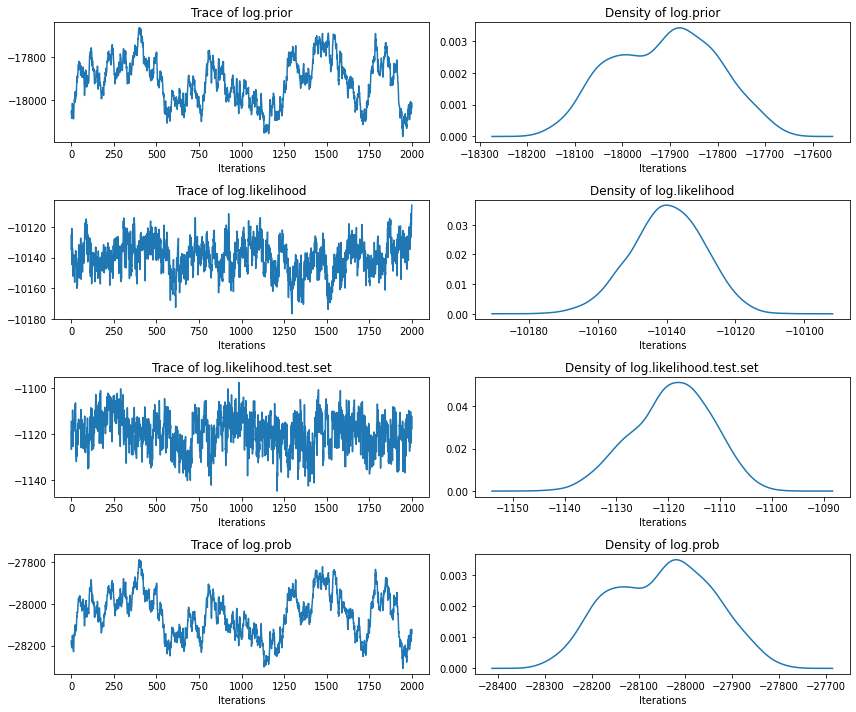

In [ ]:
fig = plt.figure(figsize=[12,10])

plt.subplot(4,2,1)
plt.plot(df_log_prob['log.prior'])
plt.xlabel('Iterations')
plt.title('Trace of log.prior')

plt.subplot(4,2,2)
x,y = getDensity(df_log_prob['log.prior'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prior')

plt.subplot(4,2,3)
plt.plot(df_log_prob['log.likelihood'])
plt.title('Trace of log.likelihood')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,4)
x,y = getDensity(df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood')

plt.subplot(4,2,5)
plt.plot(df_log_prob['log.likelihood.test.set'])
plt.title('Trace of log.likelihood.test.set')
plt.xlabel('Iterations')
plt.tight_layout()

plt.subplot(4,2,6)
x,y = getDensity(df_log_prob['log.likelihood.test.set'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.likelihood.test.set')

plt.subplot(4,2,7)
plt.plot(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.title('Trace of log.prob')
plt.xlabel('Iterations')

plt.subplot(4,2,8)
x,y = getDensity(df_log_prob['log.prior']+df_log_prob['log.likelihood'])
plt.plot(x,y)
plt.xlabel('Iterations')
plt.title('Density of log.prob')

plt.tight_layout()

plt.show()

### Plot the influence matrix between participants

In [ ]:
A = int(np.sqrt(len(df_influence.columns))) #number of participants
id_person = {}
for p in person_id:
    id_person[person_id[p]]=p

In [ ]:
def getmatrix(stacked,A):
    influence_matrix = [[0 for i in range(A)] for j in range(A)]
    for row in stacked.iteritems():
        from_ = int(row[0].split('.')[1])-1
        to_ = int(row[0].split('.')[2])-1
        value = float(row[1])
        influence_matrix[from_][to_]=value
    df_ = pd.DataFrame(influence_matrix) 
    
    df_ =df_.rename(index = id_person)
    df_ =df_.rename(columns = id_person)
    return df_

In [ ]:
stacked = df_influence.mean(axis=0)
df_mean = getmatrix(stacked,A)

stacked = df_influence.std(axis=0)
df_std = getmatrix(stacked,A)

In [ ]:
df_mean

,Juror 8,Juror 3,Juror 10,Foreman,Juror 7,Juror 4,Juror 11,Juror 12,Juror 6,Juror 2,Juror 9,Juror 5
Juror 8,0.000000,3.757957,8.089079,0.930180,5.167497,0.794645,0.845335,1.336329,6.106684,0.916765,6.385205,7.300776
Juror 3,8.529312,0.000000,6.673916,4.150076,2.534751,4.902852,1.092571,0.509942,3.825015,3.861767,0.266426,1.561626
Juror 10,8.413188,7.427932,0.000000,4.540236,3.216307,1.030049,1.004598,0.529232,2.426582,0.407460,1.233599,0.885871
Foreman,1.137060,0.612615,1.945196,0.000000,1.521390,0.834870,1.338554,3.230634,1.013511,3.534036,1.311436,4.115411
Juror 7,2.603853,5.901169,0.648844,1.969868,0.000000,1.110101,0.279870,0.608548,1.047693,2.910670,1.619475,1.570038
Juror 4,5.791320,0.200669,0.266484,0.582956,0.094200,0.000000,3.347982,0.316963,0.300770,2.112033,0.370973,0.673364
Juror 11,0.378515,0.544628,0.779340,0.454645,0.290575,0.447512,0.000000,0.614536,0.821143,0.951222,0.476986,0.844157
Juror 12,5.961338,0.695831,0.519459,1.253033,0.247939,0.162463,0.388620,0.000000,2.500976,2.375977,0.481394,0.834032
Juror 6,4.526244,0.923784,0.503503,1.049825,1.288920,0.451562,0.375776,0.904313,0.000000,2.861587,0.905421,0.310822
Juror 2,0.583732,2.303417,0.529583,1.722894,2.005939,0.299311,0.652302,1.623813,0.841376,0.000000,1.691612,1.756225


MEAN of influence matrix (row=from, col=to)


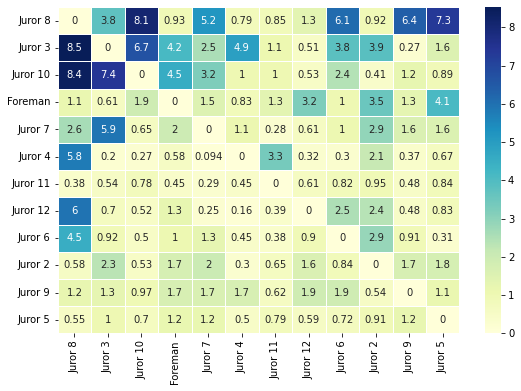

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_mean, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('MEAN of influence matrix (row=from, col=to)')
plt.show()

SD of influence matrix (row=from, col=to)


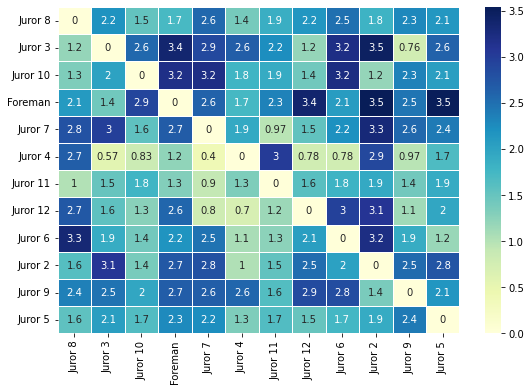

In [ ]:
f, ax = plt.subplots(figsize=(9, 6))
seaborn.heatmap(df_std, annot=True,  linewidths=.5, ax=ax,cmap="YlGnBu")
print('SD of influence matrix (row=from, col=to)')
plt.show()

### Barplot of total influences sent/received

In [ ]:
sender_std = {} #sd of total influence sent
reciever_std = {} #sd of total influence recieved
for i in range(A):
    reciever_std[id_person[i]] = df_influence[df_influence.columns[i::A]].sum(axis=1).std()
    sender_std[id_person[i]] = df_influence[df_influence.columns[i*A:(i+1)*A:]].sum(axis=1).std()

sent = df_mean.sum(axis=1) #mean of total influence sent
recieved =df_mean.sum(axis=0) #mean of total influence recieved

Total influence:

		Total linguistic influence sent/received 


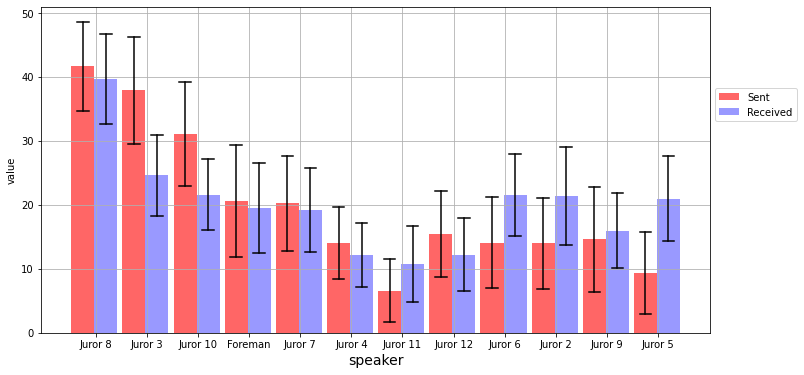

In [ ]:
print ("\t\tTotal linguistic influence sent/received ")
ax.fig = plt.figure(figsize=[np.min([A,20]),6])

plt.grid()
wd=0.45
ii=0
for p in sender_std:
    plt.bar(person_id[p],sent.loc[p],width=wd,color='red',alpha=0.6,label = "Sent" if ii == 0 else "")
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]+sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    plt.plot([person_id[p]-wd/4,person_id[p]+wd/4],[sent.loc[p]-sender_std[p],sent.loc[p]-sender_std[p]],color='k')
    plt.plot([person_id[p],person_id[p]],[sent.loc[p]-sender_std[p],sent.loc[p]+sender_std[p]],color='k')
    ii+=1
ii=0
for p in reciever_std:
    plt.bar(person_id[p]+wd,recieved.loc[p],width=wd,color='blue',alpha=0.4,label = "Received" if ii == 0 else "")
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]+reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd-wd/4,person_id[p]+wd+wd/4],[recieved.loc[p]-reciever_std[p],recieved.loc[p]-reciever_std[p]],color='k')
    plt.plot([person_id[p]+wd,person_id[p]+wd],[recieved.loc[p]-reciever_std[p],recieved.loc[p]+reciever_std[p]],color='k')
    ii+=1
plt.legend(loc='center left', bbox_to_anchor=(1, 0.7))
plt.xticks([i+0.25 for i in range(A)],list(zip(*sorted(id_person.items())))[1])
plt.ylabel('value')
plt.xlabel('speaker',fontsize=14)
plt.show()

## Visualize Influence Network!

You can visualize any of the influence matrices above:

Using networkx:

In [ ]:
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

In [ ]:
# get quantile influence matrices for 25%, 50%, 75% quantile
stacked = df_influence.quantile(0.25)
df_q25 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.5)
df_q50 = getmatrix(stacked,A)

stacked = df_influence.quantile(0.75)
df_q75 = getmatrix(stacked,A)

Mean Influence Network


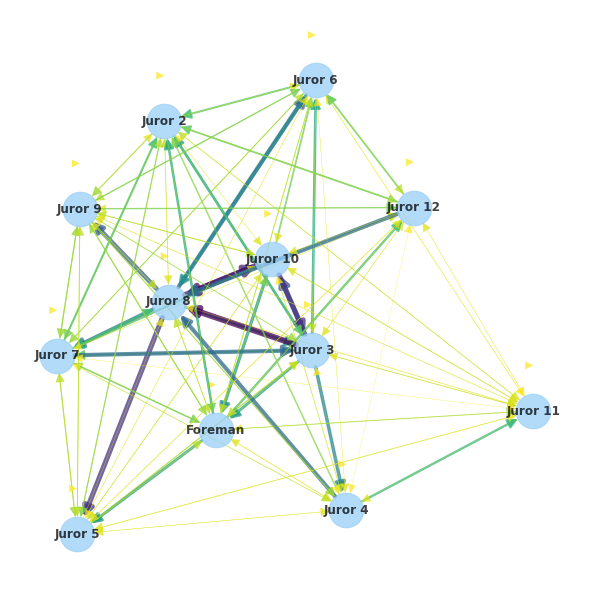

In [ ]:
G_mean = drawNetwork(df_mean,'Mean Influence Network')

25 Quantile Influence Network


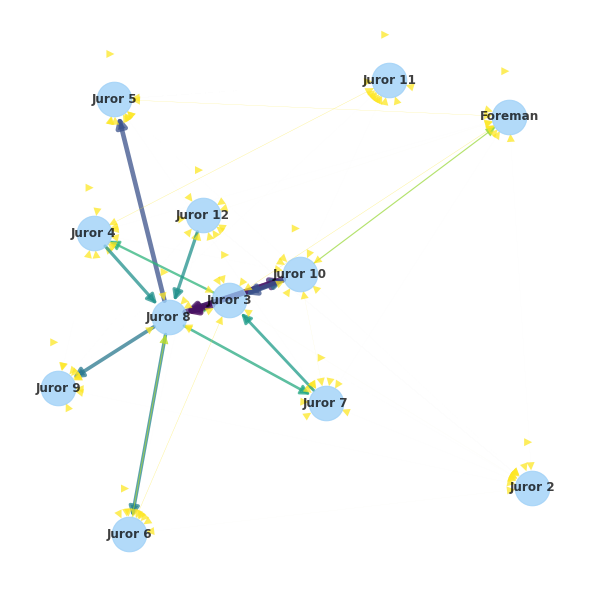

In [ ]:
G_q25 = drawNetwork(df_q25,'25 Quantile Influence Network')

75 Quantile Influence Network


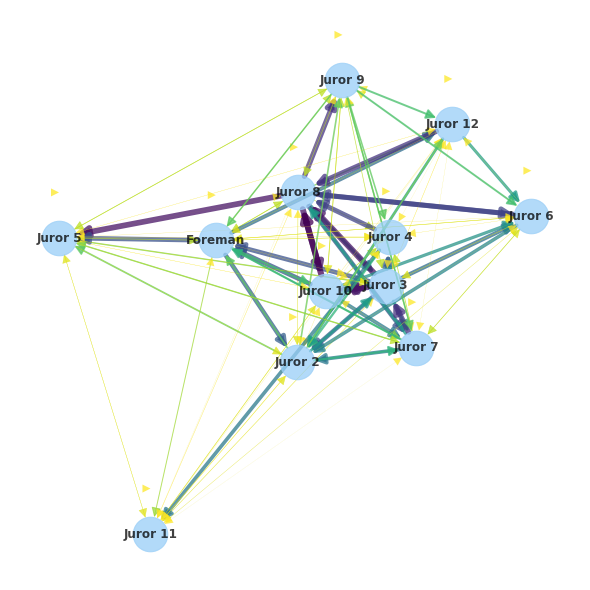

In [ ]:
G_q75 = drawNetwork(df_q75,'75 Quantile Influence Network')

In [ ]:
def fakeEnglish(length):
    listd=['a','b','c','d','e','f','g','s','h','i','j','k','l']
    return ''.join(np.random.choice(listd,length))

Your own dataset should contains 4 columns (with the same column names) as the artificial one below:

- name: name of the participant
- tokens: a list of tokens in one utterance
- start: starting time of utterance (unit doesn't matter, can be 'seconds','minutes','hours'...)
- end: ending time of utterance (same unit as start)

There is no need to sort data for the moment.

Below, we generate a fake collection of data from "Obama", "Trump", "Clinton"...and other recent presidents. You can either create your own simulation OR (better), add real interactional data from a online chat forum, comment chain, or transcribed from a conversation.

In [ ]:
script= []
language = 'eng' #parameter, no need to tune if using English, accept:{'eng','chinese'}
role = 'Adult' #parameter, no need to tune 

for i in range(290):
    dt = []
    dt.append(np.random.choice(['Obama','Trump','Clinton','Bush','Reagan','Carter','Ford','Nixon','Kennedy','Roosevelt']))
    faketokens = [fakeEnglish(length = 4) for j in range(30)]
    dt.append(faketokens) #fake utterance
    dt.append(i*2+np.random.random()) # start time
    dt.append(i*2+1+np.random.random()) # end time
    script.append(dt)

df_transcript = pd.DataFrame(script,columns=['name','tokens','start','end']) #"start", "end" are timestamps of utterances, units don't matter
df_transcript[:2]

,name,tokens,start,end
0,Kennedy,"[hikf, icid, ddds, lska, cegj, glhc, hecc, skf...",0.960867,1.089312
1,Carter,"[leki, edbf, dbas, igfe, jghc, libi, habh, edf...",2.283494,3.955509


Transform data into TalkbankXML format:

In [ ]:
output_fname = 'USpresident.xml'  #should be .xml
language = 'eng' 
#language = 'chinese'
lucem_illud.make_TalkbankXML(df_transcript, output_fname, language = language )

New File saved to .\data\USpresident\USpresident.xml


0

Run Bayesian Echo Chamber to get estimation.

- It may take a couple of hours. ( About 4-5 hours if Vocab_size=600 and sampling_time =2000)
- Larger "Vocab_size" (see below) will cost more time
- Larger "sampling_time" will also consume more time

In [ ]:
Vocab_size = 90 # up to Vocab_size most frequent words will be considered, it should be smaller than the total vocab
sampling_time = 1500  #The times of Gibbs sampling sweeps  (500 burn-in not included)
lucem_illud.bec_run(output_fname, Vocab_size, language, sampling_time)

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project (__or one from ConvoKit__). Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<font color="red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<font color="red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

In [21]:
friend = Corpus(download('friends-corpus'))

Dataset already exists at C:\Users\Rando\.convokit\downloads\friends-corpus


In [22]:
df = friend.get_utterances_dataframe()

In [23]:
df.head()

,timestamp,text,speaker,reply_to,conversation_id,meta.tokens,meta.character_entities,meta.emotion,meta.caption,meta.transcript_with_note,meta.tokens_with_note,vectors
id,,,,,,,,,,,,
s01_e01_c01_u001,None,There's nothing to tell! He's just some guy I ...,Monica Geller,None,s01_e01_c01_u001,"[[There, 's, nothing, to, tell, !], [He, 's, j...","[[], [[0, 1, Paul the Wine Guy], [4, 5, Paul t...",None,None,None,None,[]
s01_e01_c01_u002,None,"C'mon, you're going out with the guy! There's ...",Joey Tribbiani,s01_e01_c01_u001,s01_e01_c01_u001,"[[C'mon, ,, you, 're, going, out, with, the, g...","[[[2, 3, Monica Geller], [8, 9, Paul the Wine ...",None,None,None,None,[]
s01_e01_c01_u003,None,"All right Joey, be nice. So does he have a hum...",Chandler Bing,s01_e01_c01_u002,s01_e01_c01_u001,"[[All, right, Joey, ,, be, nice, .], [So, does...","[[[2, 3, Joey Tribbiani]], [[2, 3, Paul the Wi...",None,None,None,None,[]
s01_e01_c01_u004,None,"Wait, does he eat chalk?",Phoebe Buffay,s01_e01_c01_u003,s01_e01_c01_u001,"[[Wait, ,, does, he, eat, chalk, ?]]","[[[3, 4, Paul the Wine Guy]]]",None,None,None,None,[]
s01_e01_c01_u005,None,,TRANSCRIPT_NOTE,s01_e01_c01_u004,s01_e01_c01_u001,[],[],None,None,"(They all stare, bemused.)","[[(, They, all, stare, ,, bemused, ., )]]",[]


In [24]:
friends_network = nx.Graph()

In [25]:
main_char = ['Rachel Green', 'Monica Geller', 'Joey Tribbiani', 'Chandler Bing', 'Phoebe Buffay', 'Ross Geller']

In [26]:
df_main = df[df['speaker'].isin(main_char)]

In [27]:
for row in df_main.iloc:
    if row.reply_to in df_main.index:
        if 'love' in row.text:
            speaker = row.speaker
            receiver = df_main.loc[[row.reply_to]].speaker.item()

            
            if (speaker, receiver) in friends_network.edges:
                friends_network[speaker][receiver]['weight'] += 1
            
            elif (receiver, speaker) in friends_network.edges:
                    friends_network[receiver][speaker]['weight'] += 1
            
            else:
                friends_network.add_edge(speaker, receiver, weight = 1)

In [28]:
weights = [0.05*friends_network[u][v]['weight'] for u,v in friends_network.edges]

Here I constructed a network between the 6 main characters. An edge would be added if there is an utterance containing ``love`` between the two actors. The weight would be **0.05** * the number of utterances containing ``love`` bewteen the two actors.

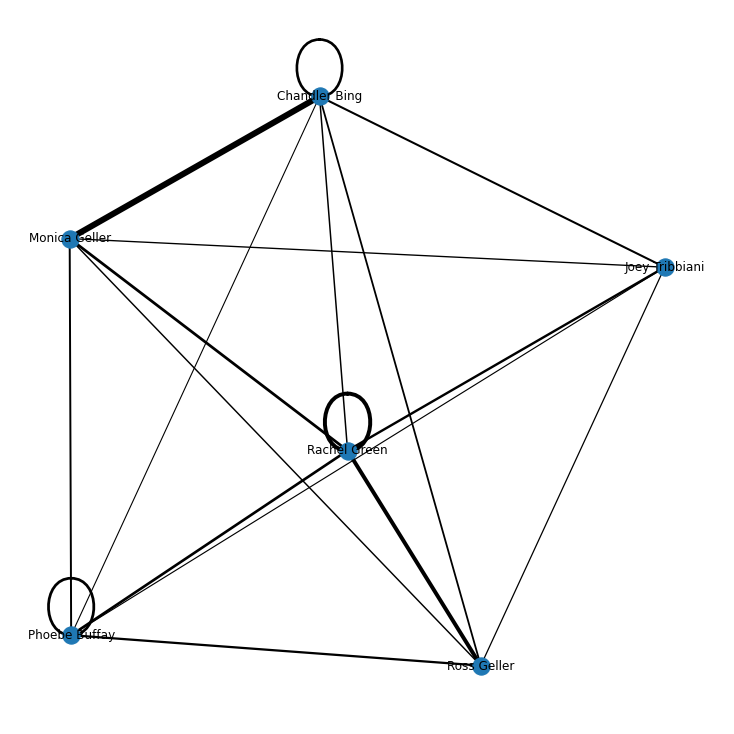

In [36]:
plt.figure(5,figsize=(10,10)) 
nx.draw(friends_network, with_labels = True, width=weights)

This is the resulting network. We can see that there are some self-loops in the graph. This is because that the corpus says that the speakers were replying to themselves. </br> 
The edge between Chandler and Monica is pretty thick, indicating a large weight.This is expected, since the love between Chandler and Monica was one of the main plotlines. Similarly, there is a thick edge between Ross and Rachel.
   Also, we can eyeball that Rachel might have high centrality score taking edge weight into consideration.

In [30]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(friends_network))

In [31]:
c

[frozenset({'Chandler Bing',
            'Joey Tribbiani',
            'Monica Geller',
            'Ross Geller'}),
 frozenset({'Rachel Green'}),
 frozenset({'Phoebe Buffay'})]

Next I conducted community analysis, and the result was that Chandler and Monica are in one community, and the rest of the four nodes are in one community. I think the reason is that the within community edge weight is too large for these two nodes. </br>
We can see it clearly from the network. The edge between Monica and Chandler is much thicker than the edges connecting them to other nodes. Even though Rachel has strong connection with Ross, the edges connecting with other nodes are also pretty thick.

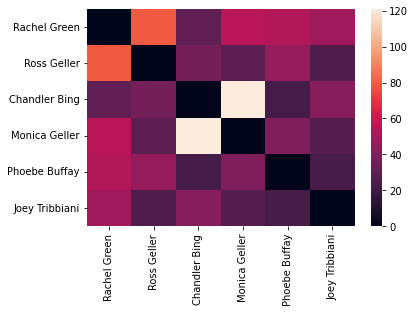

In [32]:
L = []
for node in friends_network.nodes():
    l = []
    for node_ in friends_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(friends_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pd.DataFrame(M_, columns = list(friends_network.nodes()), index = list(friends_network.nodes()))
ax = sns.heatmap(div)
plt.show()

Here is an edge weight heatmap. The lighter the color, the larger the weights. We can see that the two lightest color blocks are between Chandler and Monica and between Ross and Rachel.

In [33]:
dcentralities = nx.degree_centrality(friends_network)

In [34]:
dcentralities

{'Rachel Green': 1.4000000000000001,
 'Ross Geller': 1.0,
 'Chandler Bing': 1.4000000000000001,
 'Monica Geller': 1.0,
 'Phoebe Buffay': 1.4000000000000001,
 'Joey Tribbiani': 1.0}

In [35]:
friends_network.degree(weight='weight')

DegreeView({'Rachel Green': 267, 'Ross Geller': 214, 'Chandler Bing': 252, 'Monica Geller': 271, 'Phoebe Buffay': 188, 'Joey Tribbiani': 164})

In terms of centrality analysis, the degree centrality function provided by networkx does not consider edge weights. So a simple centrality measure method is to sum the weights of the edges for each node, and here are the results. </br>
Even though Rachel seem to have the largest degree centrality score, I guess the edge weight between Chandler and Monica is just too large, which makes Monica to have the highest degree centrality score.

## Text Generation using GPT-2 and BERT

We can make use of the transformers we learned about last week to do text generation, where the model takes one or multiple places in a conversation. While some may regard it as a parlour trick due to unpredictability, recent dramatic improvements in text generation suggest that these kind of models can find themselves being used in more serious social scientific applications, such as in survey design and construction, idiomatic translation, and the normalization of phrase and sentence meanings.

These models can be quite impressive, even uncanny in how human like they sound. Check out this [cool website](https://transformer.huggingface.co), which allows you to write with a transformer. The website is built by the folks who wrote the package we are using. The code underneath the website can be found in their examples: [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py).

We will be using the built in generate function, but the example file has more detailed code which allows you to set the seed differently.

In [ ]:
from transformers import AutoModelWithLMHead, AutoTokenizer

tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [ ]:
sequence = "Nothing that we like to do more than analyse data all day long and"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Wow. A little creepy, and as we can see, far from perfect: GPT doesn't alwats work out flawlessly, but it sometimes can, and we will try and see if fine-tuning helps. We are going to tune the model on a complete dataset of Trump tweets, as they have a set of distinctive, highly identifiable qualities.

### Creating a domain-specific language model

One of the most exciting things about BERT and GPT is being able to retune them the way we want to. We will be training models to perform two tasks - one is to create a BERT with an "accent", by traning a model with english news data from the UK, from the US, and from India. We will also train a language generation model with a bunch of Trump tweets. 

We can train models specifically over a certain domain to make its language generation similar to that domain. 
[run_language modelling.py](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py), followed by [run_generation.py](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py). I've downloaded these files and added them to this directory so we can run them through the notebook. You are encouraged to look at these files to get a rough idea of what is going on.

### Loading Data 

We want to now get our Trump tweets and our English news datasets ready. The data the scripts expect is just a text file with relevant data. We load the Trump tweets and then write them to disk as train and test files with only data. I leave the original dataframes in case you would like to use it for your own purposes.

In [ ]:
dfs = []

In [ ]:
for file in os.listdir("../data/trump_tweets"):
    dfs.append(pd.read_json("../data/trump_tweets/" + file))

In [ ]:
df = pd.concat(dfs)

In [ ]:
df.head()

In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(df['text'], test_size=0.2)

In [ ]:
train_text.head()

In [ ]:
train_text.to_frame().to_csv(r'train_text_trump', header=None, index=None, sep=' ', mode='a')

In [ ]:
test_text.to_frame().to_csv(r'test_text_trump', header=None, index=None, sep=' ', mode='a')

I now used the Google Colab GPUs to train the Trump tweet models. We'll be doing the same for our blog posts too.

### GloWBe dataset

We'll now load up the GloWbe (Corpus of Global Web-Based English) dataset which have different texts from different countries. We'll try and draw out texts from only the US, UK and India. We'll then save these to disk. Note that this is a Davies Corpora dataset: the full download can be done with the Dropbox link I sent in an announcement a few weeks ago. The whole download is about 3.5 GB but we only need two files, which are anout 250 MB each. The other files might be useful for your research purposes.

In [ ]:
address = "C:/Downloads/GloWbE"

In [ ]:
# these are the exact name of the files
us = "/text_us_blog_jfy.zip"
gb = "/text_gb_blog_akq.zip"

In [ ]:
us_texts = lucem_illud.loadDavies(address, corpus_style="us_blog", num_files=5000)

In [ ]:
gb_texts = lucem_illud.loadDavies(address, corpus_style="gb_blog", num_files=5000)

We now have a dictionary with document ids mapping to text. Since we don't need any information but the text, we can just save these to disk.

In [ ]:
' '.join(list(us_texts.values())[10])

In [ ]:
def dict_to_texts(texts, file_name):
    text = []
    for doc in list(texts.values()):
        text.append(' '.join(doc).replace("< h >", "").replace("< p >", ""))
    train_text, test_text = train_test_split(text, test_size=0.2)
    with open(file_name + "_train", 'w') as f:
        for item in train_text:
            f.write("%s\n" % item)
    
    with open(file_name + "_test", 'w') as f:
        for item in test_text:
            f.write("%s\n" % item)

In [ ]:
dict_to_texts(us_texts, "us_blog")

In [ ]:
dict_to_texts(gb_texts, "gb_blog")

We now have the training and testing files for both US and GB blogs in English. 

(WARNING - SHIFT TO GOOGLE COLAB OR GPU ENABLED MACHINE)


### Running Scripts

We use the scripts to do language modelling and text generation. The following cells run the code as if you would have run it in a terminal.

#### Trump GPT-2

In [ ]:
# You might have issues with the memory of your GPU in the following code.
# The default Google Colab GPU should work with batch size of 2,
# but if you get a "CUDA out of memory" error, you can reduce it to 1.

# !python run_language_modeling.py --per_gpu_train_batch_size=1 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
!python run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump
# !python run_language_modeling.py --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=train_text_trump --do_eval --eval_data_file=test_text_trump

# If the GPU memory error still occurs even with a batch size of 1,
# you can need to run the code on RCC Midway
# (See https://github.com/UChicago-Computational-Content-Analysis/Frequently-Asked-Questions/issues/18)

#### RoBERTa US

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_us --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=us_blog_train --do_eval --eval_data_file=us_blog_test --mlm

#### RoBERTa UK

In [ ]:
!python run_language_modeling.py --output_dir=output_roberta_gb --model_type=roberta --model_name_or_path=roberta-base --do_train --train_data_file=gb_blog_train --do_eval --eval_data_file=gb_blog_test --mlm

(If you left to use a GPU machine, COME BACK TO THIS NOTEBOOK to load and work with your trained model.)

### Loading and using models

Let us now load the four models we have and see how we can use them.

And now - let us see what our Trump Tweet Bot looks like!
You can generate text via command line using the command below. You can also load a model once it is saved - I trained my model using Google Colab, downloaded the model, and am loading it again via the command below. Note that you have to download all the files in your folder of the fine-tuned model to use the model.

In [ ]:
# !python run_generation.py --model_type=gpt2 --model_name_or_path=output_gpt_trump

In [ ]:
tokenizer_trump = AutoTokenizer.from_pretrained("output_gpt_trump")
# If this line does not work, try tokenizer_trump = AutoTokenizer.from_pretrained("gpt2")

model_trump = AutoModelWithLMHead.from_pretrained("output_gpt_trump")

In [ ]:
sequence = "Obama is going to"

input = tokenizer_trump.encode(sequence, return_tensors="pt")
generated = model_trump.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Wow - our Trump bot is nasty, so we know our model trained well. What happens if we try the same sentence for our non-fine tuned model?

In [ ]:
sequence = "Obama is going to"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_gpt.decode(generated.tolist()[0])
print(resulting_string)

Quite the contrast.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that generate a BERT-powered chatbot tuned on text related to your final project. What is interesting about this model, and how to does it compare to an untrained model? What does it reveal about the social game involved with your dataset?

In [ ]:
friend = Corpus(download('friends-corpus'))

In [ ]:
utterences = friend.get_utterances_dataframe().text

In [ ]:
from sklearn.model_selection import train_test_split
train_text, test_text = train_test_split(utterences, test_size=0.2)

In [ ]:
with open("friend_train", 'w') as f:
    for item in train_text:
        f.write("%s\n" % item)

with open("friend_test", 'w') as f:
    for item in test_text:
        f.write("%s\n" % item)

In [ ]:
!python run_language_modeling.py --per_gpu_train_batch_size=2 --output_dir=output_gpt_trump --model_type=gpt2 --model_name_or_path=gpt2 --do_train --train_data_file=friend_train --do_eval --eval_data_file=friend_test

03/04/2022 10:10:10 - WARNING - __main__ -   Process rank: -1, device: cuda, n_gpu: 1, distributed training: False, 16-bits training: False
03/04/2022 10:10:18 - INFO - __main__ -   Training/evaluation parameters Namespace(adam_epsilon=1e-08, block_size=1024, cache_dir='', config_name='', device=device(type='cuda'), do_eval=True, do_lower_case=False, do_train=True, eval_all_checkpoints=False, eval_data_file='friend_test', evaluate_during_training=False, fp16=False, fp16_opt_level='O1', gradient_accumulation_steps=1, learning_rate=5e-05, local_rank=-1, logging_steps=50, max_grad_norm=1.0, max_steps=-1, mlm=False, mlm_probability=0.15, model_name_or_path='gpt2', model_type='gpt2', n_gpu=1, no_cuda=False, num_train_epochs=1.0, num_warmup_steps=0, output_dir='output_gpt_trump', overwrite_cache=False, overwrite_output_dir=False, per_gpu_eval_batch_size=1, per_gpu_train_batch_size=2, save_steps=50, save_total_limit=None, seed=42, server_ip='', server_port='', tokenizer_name='', train_data_fi

In [ ]:
tokenizer_friends = AutoTokenizer.from_pretrained("output_gpt_trump")
# If this line does not work, try tokenizer_trump = AutoTokenizer.from_pretrained("gpt2")

model_friends = AutoModelWithLMHead.from_pretrained("output_gpt_trump")

I couldn't use the provided code to get BERT or RoBERTa to work for text generation, so I used GPT2. </br>

In [ ]:
sequence = "Love is a"

input = tokenizer_friends.encode(sequence, return_tensors="pt")
generated = model_friends.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Love is a great name.

Oh, I'm sorry.

Oh, I'm sorry.

Oh, I'm sorry.

Oh, I'm sorry.

Oh, I'm sorry.

Oh,


First I tested love is a. And the text generated by the finetuned model does not make much sense. Also, an interesting phenomenon is that both models keep generate repetitive sentences.

In [ ]:
sequence = "Do you love"

input = tokenizer_friends.encode(sequence, return_tensors="pt")
generated = model_friends.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Do you love me?

Oh, I'm sorry.

Oh, I'm sorry.

Oh, I'm sorry.

Oh, I'm sorry.

Oh, I'm sorry.

Oh, I


The second one I tested is do you love. Now text generated by the finetuned model is within our expectation, it's a typical line in TV series.

In [ ]:
sequence = "Chandler"

input = tokenizer_friends.encode(sequence, return_tensors="pt")
generated = model_friends.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Chandler, you're not gonna be able to do that.
Oh, I'm sorry.
Oh, I'm sorry.
Oh, I'm sorry.
Oh, I'm sorry.
Oh, I'm sorry.



Finally, I tested one of the main character's name Chandler. I'll compare later.

In [ ]:
tokenizer_gpt = AutoTokenizer.from_pretrained("gpt2")
model_gpt = AutoModelWithLMHead.from_pretrained("gpt2")

In [ ]:
sequence = "Love is a"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Love is a great way to get a little bit of a break from the grind.

"I'm not going to lie, I'm not going to lie to you. I'm not going to lie to you. I'm not going to


The text generated by the pretrained model is much better, and there are still repetitive sentences.

In [ ]:
sequence = "Do you love"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Do you love the way you look at it?

I love the way you look at it. I love the way you look at it. I love the way you look at it. I love the way you look at it. I love


The one generated
    by the pretrained model is also not bad. The repetitive sentences are still there.


In [ ]:
sequence = "Chandler"

input = tokenizer_gpt.encode(sequence, return_tensors="pt")
generated = model_gpt.generate(input, max_length=50, bos_token_id=1, pad_token_id=1, eos_token_ids=1)

resulting_string = tokenizer_trump.decode(generated.tolist()[0])
print(resulting_string)

Chandler, who is also a former president of the National Association of Manufacturers, said the company's decision to sell its products to the public was "a big step forward."

"We're very pleased with the decision," he said


We can see that the two models have totally different knowledge about Chandler. In the pretrained model, Chandler has been known as a former president of an association. In the fine-tuned model, Chanlder is a character.

Contextual models can also help us visualize how words in a sentence or different or similar to each other. We will try to construct sentences where words might mean different things in different countries - in the US, people might eat chips with salsa, but in the UK, chips are what Americans call french fries, and might eat it fried fish instead. 

In [ ]:
from transformers import RobertaConfig, RobertaModel, RobertaTokenizer

In [ ]:
roberta_us_model_embedding = RobertaModel.from_pretrained('roberta_us')

In [ ]:
roberta_us_tokenizer = RobertaTokenizer.from_pretrained('roberta_us')

In [ ]:
text = "Do you have your chips with fish or with salsa?" 

In [ ]:
text1 = "He went out in just his undershirt and pants." #pants are underwear in Britain; maybe closer to an undershirt
text2 = "His braces completed the outfit." #braces are suspenders (in Britain); maybe closer to an outfit
text3 = "Does your pencil have a rubber on it?" #rubber is an eraser in Britain); maybe closer to a pencil
text4 = "Was the bog closer to the forest or the house?" #bog is a toilen in Britain); maybe closer to a house
text5 = "Are you taking the trolley or the train to the grocery market" #trolley is a food carriage; possibly closer to a market

In [ ]:
def visualise_diffs(text, model, tokenizer):
    word_vecs = []
    for i in range(0, len(text.split())):
        word_vecs.append(word_vector(text, i, model, tokenizer))
    L = []
    for p in word_vecs:
        l = []
        for q in word_vecs:
            l.append(1 - cosine(p, q))
        L.append(l)
    M = np.array(L)
    fig = plt.figure()
    div = pd.DataFrame(M, columns = list(text.split()), index = list(text.split()))
    ax = sns.heatmap(div)
    plt.show()

In [ ]:
visualise_diffs(text, roberta_us_model_embedding, roberta_us_tokenizer)

In [ ]:
roberta_gb_model_embedding = RobertaModel.from_pretrained('roberta_gb')
roberta_gb_tokenizer = RobertaTokenizer.from_pretrained('roberta_gb')

In [ ]:
visualise_diffs(text, roberta_gb_model_embedding, roberta_gb_tokenizer)

## <font color="red">*Exercise 4*</font>

<font color="red">What's a research question relevant to your final project that would benefit from a generative or conversational model like GPT-2 or GPT-3? What task would you have it perform, and how would you evaluate the ouput?
    
<font color="red">_Stretch:_ Do it!

I think I can trian a generative model on the US news companies' news articles about China and other countries news articles about China (China, India, Russia). I can then design some descriminative phrases like 'China is a' or 'China can', which I expect the models to generate very different paragraphs. They may different in topics or sentiments, and I can look into the paragraphs to have some annotations on them (topics, with MTurk). This gives a finer interpretation than simply using the computational models like topic modeling. Then I can compare the topics for the generated texts.</br> </br>

I think the main difference between using generative models and simply having annotations on the news articles is that I can have an estimation of an average news article in a corpus. Also, I can test the corpus(models) reaction to some paragraph beginnings that are not in the corpus, but might give us some insights about the corpus. This cannot be done without the generative models.

# Optional: AI Dungeon
A fun way to explore the power of conversation and text generation is [AI Dungeon](https://play.aidungeon.io/main/newGame). If you select _Quick Start_, you can start a text adventure similar to the popular role-playing game Dungeons and Dragons, or the "choose your own adventure" books some of us boomers read as kids. AI Dungeon used to use GPT-2 but now uses GPT-3 to generate text in response to your actions. For example, you may begin with the prompt:

```
You are Jimmy, a wizard living in the kingdom of Larion. You have a staff and a spellbook. You finish your long journey and finally arrive at the ruin you've been looking for. You have come here searching for a mystical spellbook of great power called the book of essence. You look around and see a beautiful woman with raven hair and dark, sparkling eyes. She approaches you and asks you what you seek.

You are now before the one known as Raven.
```

You can respond with any text. I type, `I ask Raven, "What is the meaning of life?"`, to which AI Dungeon says:

```
Raven ponders the question for a moment, and then she answers. Raven says, "It is the pursuit of happiness." What is the pursuit of happiness?
```

I type, `I respond, "Happiness to me would be unearthing the treasures of the Kilarean Empire."`:

```
Raven looks at me and says, "Come with me and live out your one true life."

You go with Raven through many passages and up and down elevators.
```

Raven might be helping me unearth the treasures! Not bad!

There are a lot of tools like AI Dungeon being developed now with state-of-the-art language models. Now that you have some understanding of deep language models, you can better appreciate them—and perhaps design some of your own!